In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import logging
from pathlib import Path
import textwrap
import copy
from PIL import Image, ImageDraw, ImageFont
from waveshare_epd import epd2in7b

In [4]:
import constants


In [5]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [16]:
class textblock:
    '''Class for creating blocks of formatted and wrapped text as images using PIL(Pillow)
    
    Args
    ----
        resolution (2-tuple): width (x), height (y) in pixles of canvas
        font (Path): path to ttf font
        size (int): size in points to use for rendering text
        maxRows (int): maximum number of rows to produce (overflow rows will be discarded)
        text (str): unformatted text
        charPerRow (int): maximum number of rows to use per row
            this is automatically calculated using font, display size and english letter 
            distribution. Other letter distributions can be provided see CHARDIST
        charDist (dict): letter use distribution for calculating maximum number of char/row 
            for character set. Default set is for [A..Z, a..z].
            Format: CHARDIST = {'A': 0.0796394951934866, 'B': 0.0480421724743304,}
            For more languages see: 
                * https://en.wikipedia.org/wiki/Letter_frequency 
                * https://www.sttmedia.com/characterfrequencies
            
    Attributres
    -----------
        height (int): height in pixles of the display
        width (int): width in pixles of the display
        font (str): path to ttf font
        text (str): unformatted text
        charPerRow (int): maximum number of characters to allow per row before wrapping
        maxRows (int): maximum number of rows of text to produce (overflow rows will be discarded)
        _charDist (dict): private var containing character distribution 
        formattedText (str): word-wrapped text
    
    
    
    '''
    def __init__(self, resolution=(264, 176), font=constants.FONT, size=24, maxRows=3, text=' ',
                  coordinates=(0, 0), charPerRow=None, charDist=constants.USA_CHARDIST):
        self.height = resolution[0]
        self.width = resolution[1]
        self.font = self.setFont(fontPath=font, size=size)
        self.__charDist = charDist
        self.charPerRow = charPerRow
        self.maxRows = maxRows
        self.coordinates = coordinates
        self.text = text
        self.size = None
        self.image = None
        
    def setFont(self, fontPath, size):
        '''Get a ttf font
        Args
        ----
            fontPath (str): path to font (can be relative)
            size (int): size in points/pixles of font
            
        Returns
        -------
            PIL.ImageFont.truetype object'''

        logging.debug(f'font: {Path(fontPath).absolute()}, exists: {Path(fontPath).exists()}')
        font = ImageFont.truetype(str(Path(fontPath).absolute()), size)
        return(font)
    
    
    @property
    def charPerRow(self):
        '''int: Calculated maximum number of characters per row before wrapping
            Calculations are based on font, font size and width of canvas (x)'''
        return self.__charPerRow
    
    @charPerRow.setter
    def charPerRow(self, charPerRow):
        if charPerRow:
            self.__charPerRow = charPerRow
            return(charPerRow)
        s = ''
        n = 1000
        testFont = self.font
        # create a string of characters containing the letter distribution
        for char in self.__charDist:
            s = s+(char*int(self.__charDist[char]*n))
        logging.debug(f'using font: {self.font.getname()}, size: {self.font.size}')
        logging.debug(f'Created string of {len(s)} characters')
        sLenPX = testFont.getsize(s)[0] # string length in Pixles
        avgCharLen = sLenPX/len(s)
        charPerRow = round(self.height/avgCharLen)
        logging.debug(f'length in px: {sLenPX}, avg char length: {avgCharLen}, max chars per row: {charPerRow}')
        self.__charPerRow = charPerRow
        
    @property
    def text(self):
        '''str: unformatted text
        Sets
        ----
        text (str): unformatted text
        formattedText(str): wrapped text
        image (PIL Image): canvas containing formatted text
        size (int, int): tuple of x, y size of formatted text'''
        return self.__text

    @text.setter
    def text(self, text):
        if not text:
            text = ' '
        self.__text = text
        self.formattedText = self.wrapText(text)
        self.image, self.size = self.textImg()
        
    def wrapText(self, text=' ', charPerRow=None, maxRows=None):
        '''return a formatted text block of N rows using new line characters (\n)
        Args
        ----
        text (str): string to format
        charPerRow (int): maximum number of characters per row before wrapping
        maxRows (int): maximum number of rows to return -- overflow is discarded
        
        Returns
        -------
        string'''
        logging.debug(f'text length: {len(text)}')
        if not charPerRow:
            charPerRow = self.charPerRow
        if not maxRows:
            maxRows = self.maxRows
        try:
            wrapper = textwrap.wrap(text, width=charPerRow)
        except AttributeError as e:
            raise ValueError(f'Attribute Error: {text} is not a string; it appears to be {type(text)}')
        myText = "\n".join(wrapper[0:maxRows])
        if len(myText) < 1:
            myText = ' '
        return(myText)
    
    def textImg(self, text=None, coordinates=None):
        '''retun an PIL image containing the formatted text
        Args
        ----
        text (str): unformatted text to create into an image
        coordinates (int, int): tuple of integers for starting position of text on canvas
        
        Returns
        -------
        PIL image with formatted text'''
        logging.debug('creating text image')
        image = Image.new('1', (self.height, self.width), 255) # create a blank image 
        # get a drawing context
        draw = ImageDraw.Draw(image) # cr
        if text:
            myText = self.wrapText(text)
        else:
            myText = self.formattedText
            
        if not coordinates:
            coordinates = self.coordinates
        logging.debug(f'using text: {myText}')
        
        draw.text(coordinates, myText, font=self.font, fill=0)
        textsize = draw.textsize(myText)
        
        # return the altered image
        return(image, textsize)
    
    

In [17]:
epd = epd2in7b.EPD()
track = textblock(resolution=(epd.height, epd.width), maxRows=3, size=24, coordinates=(0, 0))
empty = textblock(resolution=(epd.height, epd.width), maxRows=1, size=10)

DEBUG:root:font: /home/pi/src/slimpi_epd/fonts/Open_Sans/OpenSans-Regular.ttf, exists: True
DEBUG:root:using font: ('Open Sans', 'Regular'), size: 24
DEBUG:root:Created string of 1978 characters
DEBUG:root:length in px: 26757, avg char length: 13.527300303336704, max chars per row: 20
DEBUG:root:text length: 1
DEBUG:root:creating text image
DEBUG:root:using text:  
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1216
DEBUG:root:font: /home/pi/src/slimpi_epd/fonts/Open_Sans/OpenSans-Regular.ttf, exists: True
DEBUG:root:using font: ('Open Sans', 'Regular'), size: 10
DEBUG:root:Created string of 1978 characters
DEBUG:root:length in px: 11298, avg char length: 5.711830131445905, max chars per row: 46
DEBUG:root:text length: 1
DEBUG:root:creating text image
DEBUG:root:using text:  
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1216


In [18]:
track.text = 'Old education him departure any arranging one prevailed. Their end whole might began her. Behaved the comfort another fifteen eat. Partiality had his themselves ask pianoforte increasing discovered. So mr delay at since place whole above miles. He to observe conduct at detract because. Way ham unwilling not breakfast furniture explained perpetual. Or mr surrounded conviction so astonished literature. Songs to an blush woman be sorry young. We certain as removal attempt.'

DEBUG:root:text length: 474
DEBUG:root:creating text image
DEBUG:root:using text: Old education him
departure any
arranging one
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1216


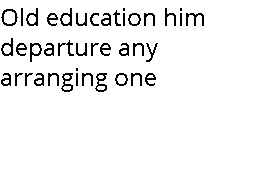

In [19]:
track.image

In [20]:
empty.text = ' '

DEBUG:root:text length: 1
DEBUG:root:creating text image
DEBUG:root:using text:  
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 1216


In [11]:
empty.text

' '

In [12]:
empty.formattedText

' '

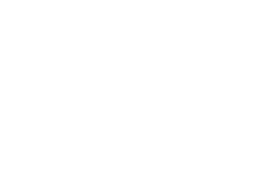

In [21]:
empty.image

In [22]:
epd.init()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release


0

In [23]:
epd.display(epd.getbuffer(track.image), epd.getbuffer(empty.image))

DEBUG:root:Horizontal
DEBUG:root:Horizontal
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release


In [ ]:
class formatter:
    def __init__(self, text, charPerRow):
        self.rows = rows
        self.charPerRow = charPerRow
        self.text = text
        
    @property
    def text(self):
        return self.__text
    
    @text.setter
    def text(self, text):
        self.__text = text
        self.formatedText = self.fmt(text, rows=self.rows, charPerRow=self.charPerRow)
        
    def fmt(self, text, rows, charPerRow):
        wrapper = textwrap.wrap(text, width=charPerRow)
        myText = "\n".join(wrapper[0:maxRows])
        return(myText)

In [ ]:
track.font.getname()